In [1]:
# Julia version of the code for Chapter 5.2 in Herbst and Schorfheide (2015)
# Author: Takeki Sunakawa
# Mail: takeki.sunakawa@gmail.com
# Last updated: April 19, 2019 @ Cafe de Crie, Kobe Motomachi

using DelimitedFiles
using Random
using ControlSystems
using Distributions
using PDMats
using StatsBase
using Plots
include("gensys.jl")

new_div (generic function with 1 method)

In [2]:
struct Model{TF<:AbstractFloat}
    tau::TF
    kappa::TF
    psi1::TF
    psi2::TF
    rA::TF
    piA::TF
    gammaQ::TF
    rho_R::TF
    rho_g::TF
    rho_z::TF
    sigma_R::TF
    sigma_g::TF
    sigma_z::TF
end

In [3]:
function model_solution(m)

    bet = 1/(1+m.rA/400)

    # Equation indices

    eq_1   = 1  #** (2.1) on \hat{y}(t) **/
    eq_2   = 2  #** (2.1) on \hat{pi}(t) **/
    eq_3   = 3  #** (2.1) on \hat{R}(t) **/
    eq_4   = 4  #** \hat{y}(t-1) **/
    eq_5   = 5  #** \hat{g} process **/
    eq_6   = 6  #** \hat{z} process **/
    eq_7   = 7  #** \hat{y} expectational error **/
    eq_8   = 8  #** \hat{pi} expectational error **/

    # Variable indices 

    y_t    = 1
    pi_t   = 2
    R_t    = 3
    y1_t   = 4
    g_t    = 5
    z_t    = 6
    Ey_t1  = 7
    Epi_t1 = 8

    # Expectation error indices (eta) 

    ey_sh  = 1
    epi_sh = 2       

    # Shock indices (eps)

    z_sh = 1
    g_sh = 2
    R_sh = 3

    # SUMMARY

    neq  = 8
    neta = 2
    neps = 3

    # /** initialize matrices **/

    GAM0 = zeros(neq,neq)
    GAM1 = zeros(neq,neq)
       C = zeros(neq,1)        
     PSI = zeros(neq,neps)
     PPI = zeros(neq,neta)


    # =========================================================================
    #                 EQUILIBRIUM CONDITIONS: CANONICAL SYSTEM
    # =========================================================================

    # =========================================================================
    #          1. 
    # =========================================================================

    GAM0[eq_1,y_t] =  1
    GAM0[eq_1,R_t] =  1/m.tau
    GAM0[eq_1,g_t] = -(1-m.rho_g)
    GAM0[eq_1,z_t] = -m.rho_z/m.tau
    GAM0[eq_1,Ey_t1] = -1
    GAM0[eq_1,Epi_t1] = -1/m.tau

    # =========================================================================
    #          2. 
    # =========================================================================

    GAM0[eq_2,y_t] = -m.kappa;
    GAM0[eq_2,pi_t] = 1;
    GAM0[eq_2,g_t] =  m.kappa;
    GAM0[eq_2,Epi_t1] = -bet;

    # =========================================================================
    #          3. 
    # =========================================================================

    GAM0[eq_3,y_t] = -(1-m.rho_R)*m.psi2
    GAM0[eq_3,pi_t] = -(1-m.rho_R)*m.psi1
    GAM0[eq_3,R_t] = 1
    GAM0[eq_3,g_t] = (1-m.rho_R)*m.psi2
    GAM1[eq_3,R_t] = m.rho_R
    PSI[eq_3,R_sh] = 1

    # =========================================================================
    #          4. 
    # =========================================================================

    GAM0[eq_4,y1_t] = 1
    GAM1[eq_4,y_t] = 1

    # =========================================================================
    #          5. 
    # =========================================================================

    GAM0[eq_5,g_t] = 1
    GAM1[eq_5,g_t] = m.rho_g
    PSI[eq_5,g_sh] = 1

    # =========================================================================
    #          6. 
    # =========================================================================

    GAM0[eq_6,z_t] = 1
    GAM1[eq_6,z_t] = m.rho_z
    PSI[eq_6,z_sh] = 1

    # =========================================================================
    #          7. 
    # =========================================================================

    GAM0[eq_7,y_t] = 1
    GAM1[eq_7,Ey_t1] = 1
    PPI[eq_7,ey_sh] = 1

    # =========================================================================
    #          8. 
    # =========================================================================

    GAM0[eq_8,pi_t] = 1
    GAM1[eq_8,Epi_t1] = 1
    PPI[eq_8,epi_sh] = 1


    # =========================================================================
    #            QZ(generalized Schur) decomposition by GENSYS
    # =========================================================================

    # [T1,TC,T0,TY,M,TZ,TETA,GEV,RC] = gensys(GAM0,GAM1,C,PSI,PPI)
    T1, TC, T0, fmat, fwt, ywt, gev, eu, loose = gensys(GAM0,GAM1,C,PSI,PPI)

    return T1, T0

end

model_solution (generic function with 1 method)

In [4]:
function sysmat(T1,T0,m)

    eq_y = 1
    eq_pi = 2
    eq_ffr = 3

    # /** number of observation variables **/

    ny = 3

    # /** model variable indices **/

    y_t    = 1
    pi_t   = 2
    R_t    = 3
    y1_t   = 4
    g_t    = 5
    z_t    = 6
    Ey_t1  = 7
    Epi_t1 = 8

    # /** shock indices **/

    z_sh = 1
    g_sh = 2
    R_sh = 3

    # =========================================================================
    #                           TRANSITION EQUATION
    #    
    #            s(t) = Phi*s(t-1) + R*e(t)
    #            e(t) ~ iid N(0,Se)
    #  
    # =========================================================================

    nep = size(T0,2)

    Phi = T1

    R   = T0

    Se  = zeros(nep,nep)

    Se[z_sh,z_sh] = (m.sigma_z)^2
    Se[g_sh,g_sh] = (m.sigma_g)^2
    Se[R_sh,R_sh] = (m.sigma_R)^2

    # =========================================================================
    #                           MEASUREMENT EQUATION
    #   
    #            y(t) = a + b*s(t) + u(t) 
    #            u(t) ~ N(0,HH)
    #  
    # =========================================================================

    A           = zeros(ny,1)
    A[eq_y,1]   = m.gammaQ
    A[eq_pi,1]  = m.piA
    A[eq_ffr,1] = m.piA+m.rA+4*m.gammaQ

    nstate = size(Phi,2)

    B = zeros(ny,nstate)

    B[eq_y,y_t]   = 1
    B[eq_y,y1_t]  = -1 
    B[eq_y, z_t]  = 1
    B[eq_pi,pi_t] = 4
    B[eq_ffr,R_t] = 4

    H = zeros(ny,ny)
    # with measurement errors (from dsge1_me.yaml)
    H[eq_y,y_t] = (0.20*0.579923)^2
    H[eq_pi,pi_t] = (0.20*1.470832)^2
    H[eq_ffr,R_t] = (0.20*2.237937)^2
    
    return A,B,H,R,Se,Phi

end    

sysmat (generic function with 1 method)

In [5]:
function nearestSPD(A)

    # symmetrize A into B
    B = (A + A')/2

    # Compute the symmetric polar factor of B. Call it H.
    # Clearly H is itself SPD.
    U,Sigma,V = svd(B)
    # println(size(U))
    # println(size(Sigma))
    # println(size(V))
    H = V*diagm(0=>Sigma)*V'

    # get Ahat in the above formula
    Ahat = (B+H)/2

    # ensure symmetry
    Ahat = (Ahat + Ahat')/2

    p = 1
    k = 0

    while (p != 0) 
        p = 0
        try
            R = cholesky(Ahat)
        catch
            p = 1
        end    

        if (p != 0)
            k = k + 1
            mineig = -maximum(-eigvals(Ahat))
            Ahat = Ahat + (-mineig*k^2 + eps(mineig))*Matrix(1.0I,size(A,1),size(A,1))
        end

    end

    return Ahat
end

nearestSPD (generic function with 1 method)

In [6]:
function PF_lik(A, B, H, Phi, R, S2, N, yt, x0, P0, resample)

    # housekeeping
    ne        = size(S2,1)
    # [~, ns] = size(B);
    ns = size(B,2)
    T         = size(yt,1)
    temp = cholesky(S2)
    sqrtS2 = R*temp.U'
    # sqrtS2    = R*cholesky(S2)'

    # matrix for store
    all_s_up  = zeros(T,ns,N) # resampled
    lik       = zeros(T,1)
    Neff      = zeros(T,1)

    # initialization
    temp_s = x0
    temp_P = P0
    temp = cholesky(temp_P)
    s_up = repeat(temp_s,1,N) + temp.U'*randn(ns,N)
    # s_up   = repmat(temp_s, 1, N) + chol(temp_P)'*randn(ns, N)

    weights = ones(N,1)

    yy = zeros(3,1)

    # Rest of Steps
    for tt=1:1:T
    # tt = 1

        yy[:,1] = yt[tt,:]'

        # Propagate
        s_fore = Phi*s_up + sqrtS2*randn(ne,N)

        # Un-normalized weights (naive boostrap particle filter)
        perror = repeat(yy-A,1,N) - B*s_fore
        d = MvNormal(PDMat(H))
        density = pdf(d,perror)
    #     density = mvnpdf(perror', zeros(1,size(yy,2)), H)

        # Store results
        lik[tt,1]        = log(mean(density.*weights))
        all_s_up[tt,:,:] = s_up

        # Normalize weights
        weights = (density.*weights)./(mean(density.*weights))

        # Effective sample size
        Neff[tt,1] = (N^2)/sum(weights.^2)
    #     s1 = sample(collect(1:N),Weights(weights[:,1]),1,replace=true)

        if resample == 1 && Neff[tt,1] <= N/2
            s_up = s_fore[:,sample(collect(1:N),Weights(weights[:,1]),N,replace=true)] # Resampling if ESS falls below a threshold
            weights = ones(N,1)
        else
            s_up = s_fore
        end    

    end

    return lik, all_s_up, Neff
end

PF_lik (generic function with 1 method)

In [23]:
# main

# yt = load('us.txt')
yt = readdlm("us.txt")

m = Model(2.09,0.98,2.25,0.65,0.34,3.16,0.51,0.81,0.98,0.93,0.19,0.65,0.24)
T1,T0 = model_solution(m)
A,B,H,R,S2,Phi = sysmat(T1,T0,m)

ns = size(B,2)

rng = MersenneTwister(111122)

# A = dlyap(Phi,R*S2*R') # ControlSystems
x0 = zeros(ns)
P0 = nearestSPD(dlyap(Phi,R*S2*R')) # to make it positive semidefinite

N = 20000 # number of particles 

lik, all_s_up, Neff = PF_lik(A, B, H, Phi, R, S2, N, yt, x0, P0, 1);

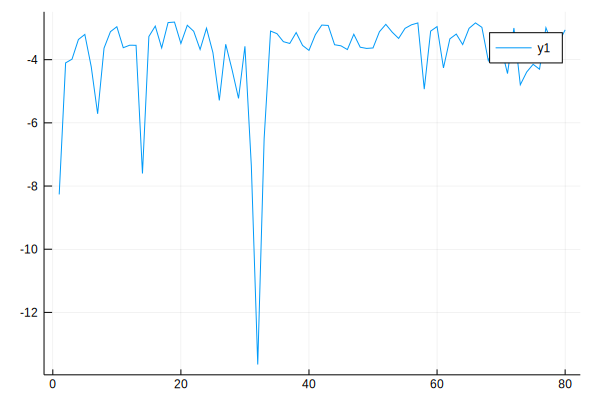

In [24]:
plot(lik)

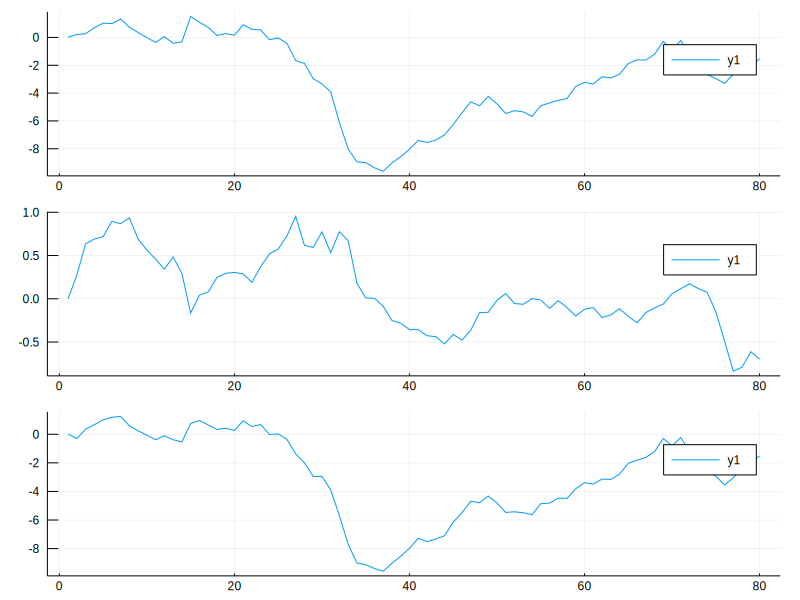

In [25]:
plot(
#     plot(all_s_up[:,5,:]),
#     plot(all_s_up[:,6,:]),
#     plot(all_s_up[:,1,:]),
    plot(mean(all_s_up[:,5,:],dims=2)),
    plot(mean(all_s_up[:,6,:],dims=2)),
    plot(mean(all_s_up[:,1,:],dims=2)),
    layout=(3,1),size=(800,600)
)